# Import packages

In [13]:
import pickle  # Local Python (3.8) is fine with this. If you're suing Google
# colab, which uses a Python version of 3.6, you need to do import pickel5
# as pickle
import cloudpickle as cp
from urllib.request import urlopen

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.cluster import MiniBatchKMeans
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
from imblearn.combine import SMOTEENN

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from collinearity import SelectNonCollinear

# Custom functions

In [2]:
from dataset_expansion import dataset_feature_expansion, merge_multiple_dfs
from dataset_cleanup import filter_low_variance
from dataset_plot import simple_pie_plot



Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


# Read in data

## Regression

In [ ]:
regression_df = pd.read_csv('datasets\cleaned_datasets\BBB_regression.csv')
regression_df

In [ ]:
(regression_df['logBB'] <= -1.01).sum()  #These are BBB-

In [ ]:
(regression_df['logBB'] >= -1).sum()  #These are BBB+

## Classification

In [ ]:
classification_df = pd.read_csv(
    'datasets\cleaned_datasets\BBB_classification.csv'
)
classification_df

In [ ]:
classification_df['BBB+/BBB-'].value_counts()

# Dataset expansion & cleaning
Major expansion steps:
1. Add in RDKit descriptors
2. Add in Morgan fingerprints
3. Add in MACCS keys

Major cleaning steps:
1. Remove columns whose variance is 0--all values are hte same
    * Done by a function so later the threshold for filtering
    based on variance level is adjustable

## Regression

In [ ]:
regression_df_expanded, regression_expansion_errors = dataset_feature_expansion(
    regression_df)
regression_df_expanded  #Missing SMILES are the chemicals that have errors
# when going through the calculations

In [ ]:
regression_df_expanded_cleaned = filter_low_variance(
    regression_df_expanded,
    exclude_col_list=['SMILES', 'logBB'],
    threshold_level=0
)
regression_df_expanded_cleaned

In [ ]:
regression_df_expanded_cleaned.to_csv(
    'datasets\expanded_datasets\BBB_regression_expanded.csv.zip',
    index=False,
    compression='zip'  # Have to use zip here since the classification
    # dataset will become very large. Zipped .csv files can be directly read
    # by pd.read_csv()
)
print('Done!')

## Classification

In [ ]:
classification_df_expanded, classification_expansion_errors = dataset_feature_expansion(
    classification_df)
classification_df_expanded

In [ ]:
classification_df_expanded_cleaned = filter_low_variance(
    classification_df_expanded,
    exclude_col_list=['SMILES', 'BBB+/BBB-'],
    threshold_level=0
)
classification_df_expanded_cleaned

In [ ]:
classification_df_expanded_cleaned.to_csv(
    'datasets\expanded_datasets\BBB_classification_expanded.csv.zip',
    index=False,
    compression='zip'
)
print('Done!')

# Dataset rebalance
Before center and standardization

## Regression
Regression dataset doesn't need rebalancing

## Classification

In [3]:
classification_df_expanded_cleaned = pd.read_csv(
    'datasets\expanded_datasets\BBB_classification_expanded.csv.zip')
classification_df_expanded_cleaned

,SMILES,BBB+/BBB-,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,...,157_y,158_y,159_y,160_y,161_y,162_y,163_y,164_y,165_y,166_y
0,O=C(O)c1cc(N=Nc2ccc(S(=O)(=O)Nc3ccccn3)cc2)ccc1O,BBB-,12.341010,12.341010,0.023055,-3.794932,0.540588,11.428571,398.400,384.288,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
1,COC1(NC(=O)C(C(=O)O)c2ccc(O)cc2)C(=O)N2C(C(=O)...,BBB-,13.190522,13.190522,0.042537,-2.144257,0.133795,22.000000,520.480,500.320,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,Oc1c(I)cc(Cl)c2cccnc12,BBB-,9.654043,9.654043,0.195000,0.195000,0.758308,10.615385,305.502,300.462,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
3,CCNC(=NCCSCc1ncccc1Br)NC#N,BBB-,8.544584,8.544584,0.532052,0.532052,0.272365,10.894737,342.266,326.138,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
4,CN1CC[C@]23c4c5ccc(OC6O[C@H](C(=O)O)[C@@H](O)[...,BBB-,11.445328,11.445328,0.165306,-1.798901,0.346256,45.303030,461.467,434.251,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7797,c1ccc(CN(CC2=NCCN2)c2ccccc2)cc1,BBB-,4.506501,4.506501,0.832250,0.832250,0.899820,13.700000,265.360,246.208,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0
7798,CCOCCn1c(N2CCCN(C)CC2)nc2ccccc21,BBB+,5.564458,5.564458,0.733727,0.733727,0.793110,17.090909,302.422,276.214,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
7799,CN1CCC(=C2c3ccccc3CC(=O)c3sccc32)CC1,BBB+,12.589347,12.589347,0.264794,0.264794,0.732528,18.863636,309.434,290.282,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
7800,Cc1[nH]c(=O)c(C#N)cc1-c1ccncc1,BBB-,11.364205,11.364205,0.122604,-0.349254,0.778670,9.750000,211.224,202.152,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


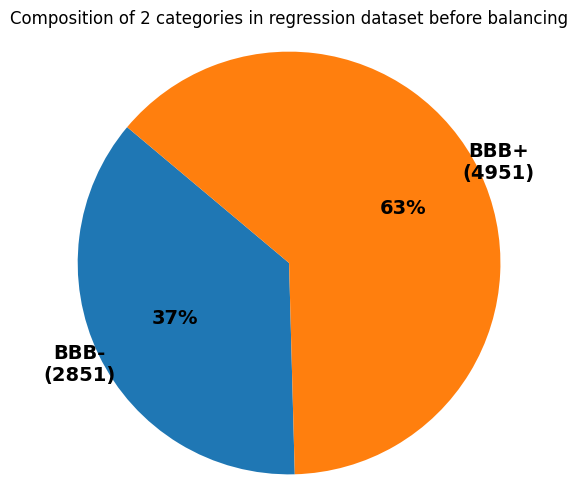

In [4]:
classification_BBB_N = (classification_df_expanded_cleaned
[classification_df_expanded_cleaned['BBB+/BBB-'] == 'BBB-']).shape[0]  #These
# are BBB-
classification_BBB_Y = (classification_df_expanded_cleaned
[classification_df_expanded_cleaned['BBB+/BBB-'] == 'BBB+']).shape[0]  #These
# are BBB+

simple_pie_plot(
    label_list=['BBB-', 'BBB+'],
    num_list=[classification_BBB_N, classification_BBB_Y],
    title_str='Composition of 2 categories in regression dataset before balancing'
)
plt.show()

In [14]:
X = classification_df_expanded_cleaned.loc[
    :,
    ~classification_df_expanded_cleaned.columns.isin(['SMILES', 'BBB+/BBB-'])
]
y = classification_df_expanded_cleaned['BBB+/BBB-']

### Under-sampling by ClusterCentroids

In [5]:
cluster_centroids = ClusterCentroids(
    estimator=MiniBatchKMeans(n_init=1, random_state=1),
    random_state=1
)



X_resample, y_resample = cluster_centroids.fit_resample(X, y)

classification_df_after_centroid_balancing = merge_multiple_dfs\
    (df_list=[classification_df_expanded_cleaned['SMILES'], y_resample, X_resample])
classification_df_after_centroid_balancing

,SMILES,BBB+/BBB-,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,...,157_y,158_y,159_y,160_y,161_y,162_y,163_y,164_y,165_y,166_y
0,O=C(O)c1cc(N=Nc2ccc(S(=O)(=O)Nc3ccccn3)cc2)ccc1O,BBB+,7.521176,7.521176,0.635885,0.411976,0.787615,16.129212,268.543,251.743,...,1.0,0.777778,0.333333,1.0,0.777778,1.0,1.0,1.0,1.0,0.0
1,COC1(NC(=O)C(C(=O)O)c2ccc(O)cc2)C(=O)N2C(C(=O)...,BBB+,15.163364,15.163364,0.020535,-1.624425,0.147925,26.905882,1202.635,1090.747,...,1.0,1.000000,1.000000,1.0,1.000000,0.0,0.0,1.0,1.0,0.0
2,Oc1c(I)cc(Cl)c2cccnc12,BBB+,15.022344,15.022344,0.036460,-1.947471,0.109538,42.500000,1085.156,1008.548,...,1.0,0.000000,1.000000,1.0,0.000000,1.0,1.0,1.0,1.0,0.0
3,CCNC(=NCCSCc1ncccc1Br)NC#N,BBB+,15.129540,15.129540,0.022871,-1.609940,0.147925,26.905882,1202.635,1090.747,...,1.0,1.000000,1.000000,1.0,1.000000,0.0,0.0,1.0,1.0,0.0
4,CN1CC[C@]23c4c5ccc(OC6O[C@H](C(=O)O)[C@@H](O)[...,BBB+,14.995286,14.995286,0.035518,-1.944947,0.109538,42.500000,1085.156,1008.548,...,1.0,0.000000,1.000000,1.0,0.000000,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5697,CCCCCCCCCCCCCCCCCCCCCCO,BBB-,11.219721,11.219721,0.047430,-0.047430,0.770309,17.750000,256.092,249.036,...,0.0,1.000000,0.000000,0.0,1.000000,1.0,1.0,1.0,1.0,0.0
5698,CCCCCCCCCCCCCCCCO,BBB-,12.530603,12.530603,0.037140,-1.168657,0.614448,15.760000,332.311,320.215,...,1.0,0.000000,1.000000,0.0,0.000000,1.0,1.0,1.0,1.0,0.0
5699,CCCCCCCCCCCCCCCC[N+](C)(C)CCN(Cc1ccc(OC)cc1)c1...,BBB-,4.506501,4.506501,0.832250,0.832250,0.899820,13.700000,265.360,246.208,...,0.0,1.000000,0.000000,0.0,1.000000,1.0,1.0,0.0,1.0,0.0
5700,CCCCCCCCCCCCCCOS(=O)(=O)O,BBB-,11.364205,11.364205,0.122604,-0.349254,0.778670,9.750000,211.224,202.152,...,0.0,0.000000,0.000000,1.0,1.000000,1.0,1.0,1.0,1.0,0.0


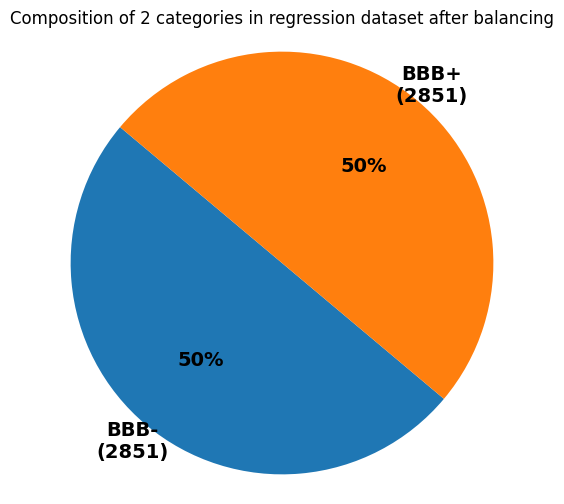

In [6]:
classification_BBB_N = (classification_df_after_centroid_balancing
[classification_df_after_centroid_balancing['BBB+/BBB-'] == 'BBB-']).shape[0]  #These
# are BBB-
classification_BBB_Y = (classification_df_after_centroid_balancing
[classification_df_after_centroid_balancing['BBB+/BBB-'] == 'BBB+']).shape[0]  #These
# are BBB+

simple_pie_plot(
    label_list=['BBB-', 'BBB+'],
    num_list=[classification_BBB_N, classification_BBB_Y],
    title_str='Composition of 2 categories in regression dataset after '
              'balancing by centroids method'
)
plt.show()

In [12]:
classification_df_after_centroid_balancing.to_csv(
    r'datasets\balanced_datasets\BBB_classification_balanced_centroid.csv.zip',
    index=False,
    compression='zip'
)
print('Done!')

Done!


### Over-sample by SMOTE then cleaning using ENN
Not using SMOTE only to create lots of hypothetical chemicals that might
not exist

In [16]:
smoteenn = SMOTEENN(random_state=1)

X_resample, y_resample = smoteenn.fit_resample(X, y)

classification_df_after_smoteenn_balancing = merge_multiple_dfs\
    (df_list=[classification_df_expanded_cleaned['SMILES'], y_resample, X_resample])
classification_df_after_smoteenn_balancing

,SMILES,BBB+/BBB-,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,...,157_y,158_y,159_y,160_y,161_y,162_y,163_y,164_y,165_y,166_y
0,O=C(O)c1cc(N=Nc2ccc(S(=O)(=O)Nc3ccccn3)cc2)ccc1O,BBB+,12.955912,12.955912,0.038527,-0.090963,0.541356,17.514286,477.649,438.337,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,COC1(NC(=O)C(C(=O)O)c2ccc(O)cc2)C(=O)N2C(C(=O)...,BBB+,11.988073,11.988073,0.084512,-0.304363,0.493562,25.181818,314.426,284.186,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
2,Oc1c(I)cc(Cl)c2cccnc12,BBB+,12.226486,12.226486,0.111551,-0.322514,0.550314,10.928571,373.416,354.264,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,CCNC(=NCCSCc1ncccc1Br)NC#N,BBB+,12.055386,12.055386,0.034054,-0.791056,0.396405,21.000000,304.302,288.174,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,CN1CC[C@]23c4c5ccc(OC6O[C@H](C(=O)O)[C@@H](O)[...,BBB+,12.055386,12.055386,0.034054,-0.791056,0.396405,21.000000,304.302,288.174,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7013,CC1(C)S[C@@H]2[C@H](NC(=O)C34C[C@H]5C[C@@H](CC...,BBB-,12.990847,12.990847,0.047104,-0.275467,0.727574,24.518519,416.349,389.133,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
7014,CC1(C)S[C@@H]2[C@H](NC(=O)CCC[C@H](N)C(=O)O)C(...,BBB-,13.528728,13.528728,0.001028,-2.638422,0.205427,30.258065,429.429,406.245,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
7015,CC1(C)S[C@@H]2[C@H](NC(=O)[C@@H](C(=O)O)c3cccc...,BBB-,14.197646,14.197646,0.133072,-1.798815,0.238475,49.615385,748.996,676.420,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
7016,CC1(C)S[C@@H]2[C@H](NC(=O)[C@@H](C(=O)O)c3ccsc...,BBB-,12.031231,12.031231,0.080972,-4.151088,0.656447,21.350000,380.662,372.598,...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0


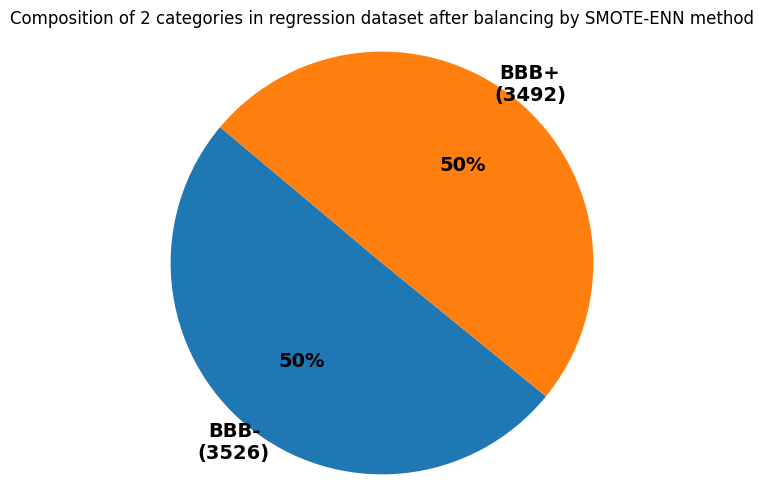

In [18]:
classification_BBB_N = (classification_df_after_smoteenn_balancing
[classification_df_after_smoteenn_balancing['BBB+/BBB-'] == 'BBB-']).shape[0]  #These
# are BBB-
classification_BBB_Y = (classification_df_after_smoteenn_balancing
[classification_df_after_smoteenn_balancing['BBB+/BBB-'] == 'BBB+']).shape[0]  #These
# are BBB+

simple_pie_plot(
    label_list=['BBB-', 'BBB+'],
    num_list=[classification_BBB_N, classification_BBB_Y],
    title_str='Composition of 2 categories in regression dataset after '
              'balancing by SMOTE-ENN method'
)
plt.show()

In [19]:
classification_df_after_smoteenn_balancing.to_csv(
    r'datasets\balanced_datasets\BBB_classification_balanced_smoteenn.csv.zip',
    index=False,
    compression='zip'
)
print('Done!')

Done!


# Model training
Datasets transformation will be done along the way

## Regression

## Classification